In [2]:
sandbox = 'fusa'
PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/diabetes/'

# Python Workshop

We load a dataset concerning hospital admissions due to diabetes. The aim of the workshop, once the dataset has been properly cleaned, is to study the dataset in order to extract the maximum number of insights.

## Load libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, random
from copy import deepcopy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsRegressor , KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



seed = 1

## Read datasets

In [5]:
diabetes = spark.read.csv(PATH_DATA+'diabetic_data.csv', sep=',', header=True, inferSchema=True).toPandas()
admission_source = spark.read.csv(PATH_DATA+'admission_source_id.csv', sep=',', header=True, inferSchema=True).toPandas()
admission_type = spark.read.csv(PATH_DATA+'admission_type_id.csv', sep=',', header=True, inferSchema=True).toPandas()
discharge_disposition = spark.read.csv(PATH_DATA+'discharge_disposition_id.csv', sep=',', header=True, inferSchema=True).toPandas()

In [6]:
def save_point(df):
    return deepcopy(df)

### Check the correct reading of the data

In [7]:
diabetes.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


In [8]:
admission_source.head(3)

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral


In [9]:
admission_type.head(3)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective


In [10]:
discharge_disposition.head(3)

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF


In [11]:
diabetes.shape, admission_source.shape, admission_type.shape, discharge_disposition.shape

((101766, 50), (25, 2), (8, 2), (30, 2))

### Gather all the data in the same DataFrame

In [12]:
def change_column_name(df, dic):
    """Return a new dataframe with the new column names"""
    return df.rename(columns = dic)

In [13]:
admission_source = admission_source.set_index('admission_source_id')
admission_type = admission_type.set_index('admission_type_id')
discharge_disposition = discharge_disposition.set_index('discharge_disposition_id')

In [14]:
complete_df = diabetes.join(admission_source,lsuffix='_diabetes', rsuffix='_admission_source', on='admission_source_id')
    
complete_df = change_column_name(complete_df, {'description' : 'admission_source_desc'})    

In [15]:
complete_df = complete_df.join(admission_type,lsuffix='_diabetes', rsuffix='_admission_type', on='admission_type_id')
    
complete_df = change_column_name(complete_df, {'description' : 'admission_type_desc'}) 

In [16]:
complete_df = complete_df.join(discharge_disposition,lsuffix='_diabetes', rsuffix='_discharge_disposition', on='discharge_disposition_id')
    
complete_df = change_column_name(complete_df, {'description' : 'discharge_disposition_desc'}) 

In [17]:
complete_df.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home


### Study the dimensions of the dataset

In [18]:
complete_df.shape

(101766, 53)

## Data Wrangling

### Change column names to perform with good practices

In [19]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 53 columns):
encounter_id                  101766 non-null int64
patient_nbr                   101766 non-null int64
race                          101766 non-null object
gender                        101766 non-null object
age                           101766 non-null object
weight                        101766 non-null object
admission_type_id             101766 non-null int64
discharge_disposition_id      101766 non-null int64
admission_source_id           101766 non-null int64
time_in_hospital              101766 non-null int64
payer_code                    101766 non-null object
medical_specialty             101766 non-null object
num_lab_procedures            101766 non-null int64
num_procedures                101766 non-null int64
num_medications               101766 non-null int64
number_outpatient             101766 non-null int64
number_emergency              101766 non-null int64

In [20]:
rename_dic = {
    'diabetesMed' : 'diabetes_med',
    'A1Cresult' : 'A1C_result',
    'time_in_hospital' : 'hospital_time',
    'number_diagnoses' : 'num_diag',
    'number_outpatient' : 'num_outpatient',
    'number_inpatient' : 'num_inpatient',
    'number_emergency' : 'num_emergency',
    'patient_nbr' : 'patient_num',
    'age' : 'age_interval',
    'diag_1' : 'sugar_lvl_1',
    'diag_2' : 'sugar_lvl_2',
    'diag_3' : 'sugar_lvl_3',
    'weight' : 'weight_interval'
}

complete_df = change_column_name(complete_df, rename_dic)

### Study the format of the variables, see which ones should be modified and modify them when appropriate.

In [21]:
def replace_char(col, char):
    """replace the char to null in the given column"""
    return pd.Series([None if x == char else x for x in col])

def change_dtype(df,dict_dtypes):
    """change the type for column [key] to type [value]"""
    for k,v in dict_dtypes.items():
        df[k] = df[k].astype(v)
    return df

def remove_char_from_num(col):
    """Regexp to remove letters from numbers"""
    return col.str.replace('[A-Za-z]','')

In [22]:
""" age is object and it should be int"""
""" we need to look into payer code"""
""" we need to look into diag_1 ...2...3"""
""" we need to look into max_glu_serum"""
""" we need to look into AC1_result"""
""" we need to look into readmitted"""
""" we need to look into weight"""

research_cols = ['weight_interval','age_interval','payer_code','sugar_lvl_1','sugar_lvl_2','sugar_lvl_3','max_glu_serum','A1C_result','readmitted']
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 53 columns):
encounter_id                  101766 non-null int64
patient_num                   101766 non-null int64
race                          101766 non-null object
gender                        101766 non-null object
age_interval                  101766 non-null object
weight_interval               101766 non-null object
admission_type_id             101766 non-null int64
discharge_disposition_id      101766 non-null int64
admission_source_id           101766 non-null int64
hospital_time                 101766 non-null int64
payer_code                    101766 non-null object
medical_specialty             101766 non-null object
num_lab_procedures            101766 non-null int64
num_procedures                101766 non-null int64
num_medications               101766 non-null int64
num_outpatient                101766 non-null int64
num_emergency                 101766 non-null int64

In [23]:
complete_df[research_cols].sample(3)
# we need to check unique values for age interval
# we need to check unique values for payer_code
# we need to cast sugar_lvl_1 ...2...3 to float
# Unique values in max_glu_serum
# Unique values in A1C_result

,weight_interval,age_interval,payer_code,sugar_lvl_1,sugar_lvl_2,sugar_lvl_3,max_glu_serum,A1C_result,readmitted
19286,?,[70-80),?,276,293,242,Norm,None,>30
85271,?,[50-60),?,38,785,276,None,>7,NO
48260,?,[70-80),SP,410,518,507,None,None,<30


In [24]:
# We want to convert all the null values to real null. We have identified that we have ? and None strings in several columns
for col in complete_df.columns:
    complete_df[col] = replace_char(complete_df[col], '?')
    complete_df[col] = replace_char(complete_df[col], 'None')

In [25]:
# First we remove chars from numbers
complete_df['sugar_lvl_1'] = remove_char_from_num(complete_df['sugar_lvl_1'])
complete_df['sugar_lvl_2'] = remove_char_from_num(complete_df['sugar_lvl_2'])
complete_df['sugar_lvl_3'] = remove_char_from_num(complete_df['sugar_lvl_3'])

In [26]:
# We cast numbers as floats

format_dict = {
    'sugar_lvl_1' : 'float64',
    'sugar_lvl_2' : 'float64',
    'sugar_lvl_3' : 'float64'
}

complete_df = change_dtype(complete_df, format_dict)

### Study if there are repeated records

In [27]:
## We don't have whole rows duplicated
complete_df.duplicated().sum()

0

In [28]:
## We have 30k patients that have come at least twice
complete_df['patient_num'].duplicated().sum()

30248

In [29]:
complete_df['encounter_id'].duplicated().sum()

0

In [30]:
complete_df[complete_df['patient_num'].duplicated(keep=False)].sort_values(by='patient_num').head()

,encounter_id,patient_num,race,gender,age_interval,weight_interval,admission_type_id,discharge_disposition_id,admission_source_id,hospital_time,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetes_med,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc
4780,26264286,135,Caucasian,Female,[50-60),None,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
4267,24437208,135,Caucasian,Female,[50-60),None,2,1,1,8,...,No,No,No,No,Ch,Yes,<30,Physician Referral,Urgent,Discharged to home
1164,8380170,1152,AfricanAmerican,Female,[50-60),None,1,1,7,6,...,No,No,No,No,No,Yes,>30,Emergency Room,Emergency,Discharged to home
5953,30180318,1152,AfricanAmerican,Female,[50-60),None,1,1,7,6,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
23623,80742510,1152,AfricanAmerican,Female,[60-70),None,1,1,7,8,...,No,No,No,No,No,Yes,>30,Emergency Room,Emergency,Discharged to home


### Study if there are variables that always or practically always take the same value: taking always the same value does not provide information to the model.

In [31]:
for col in research_cols:
    print('_____' + col + '_____')
    print(complete_df[col].unique())
    print(complete_df[col].value_counts())
# A1C is a blood test for type 2 diabetes and prediabetes. it measures your average blood glucose. > 6.4 means type 2 diabetes
# so we can change this column to be > 7 or < 7.

_____weight_interval_____
[None '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight_interval, dtype: int64
_____age_interval_____
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age_interval, dtype: int64
_____payer_code_____
[None 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC'
 'OT' 'OG' 'MP' 'FR']
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code

### Study the nulls in the dataset

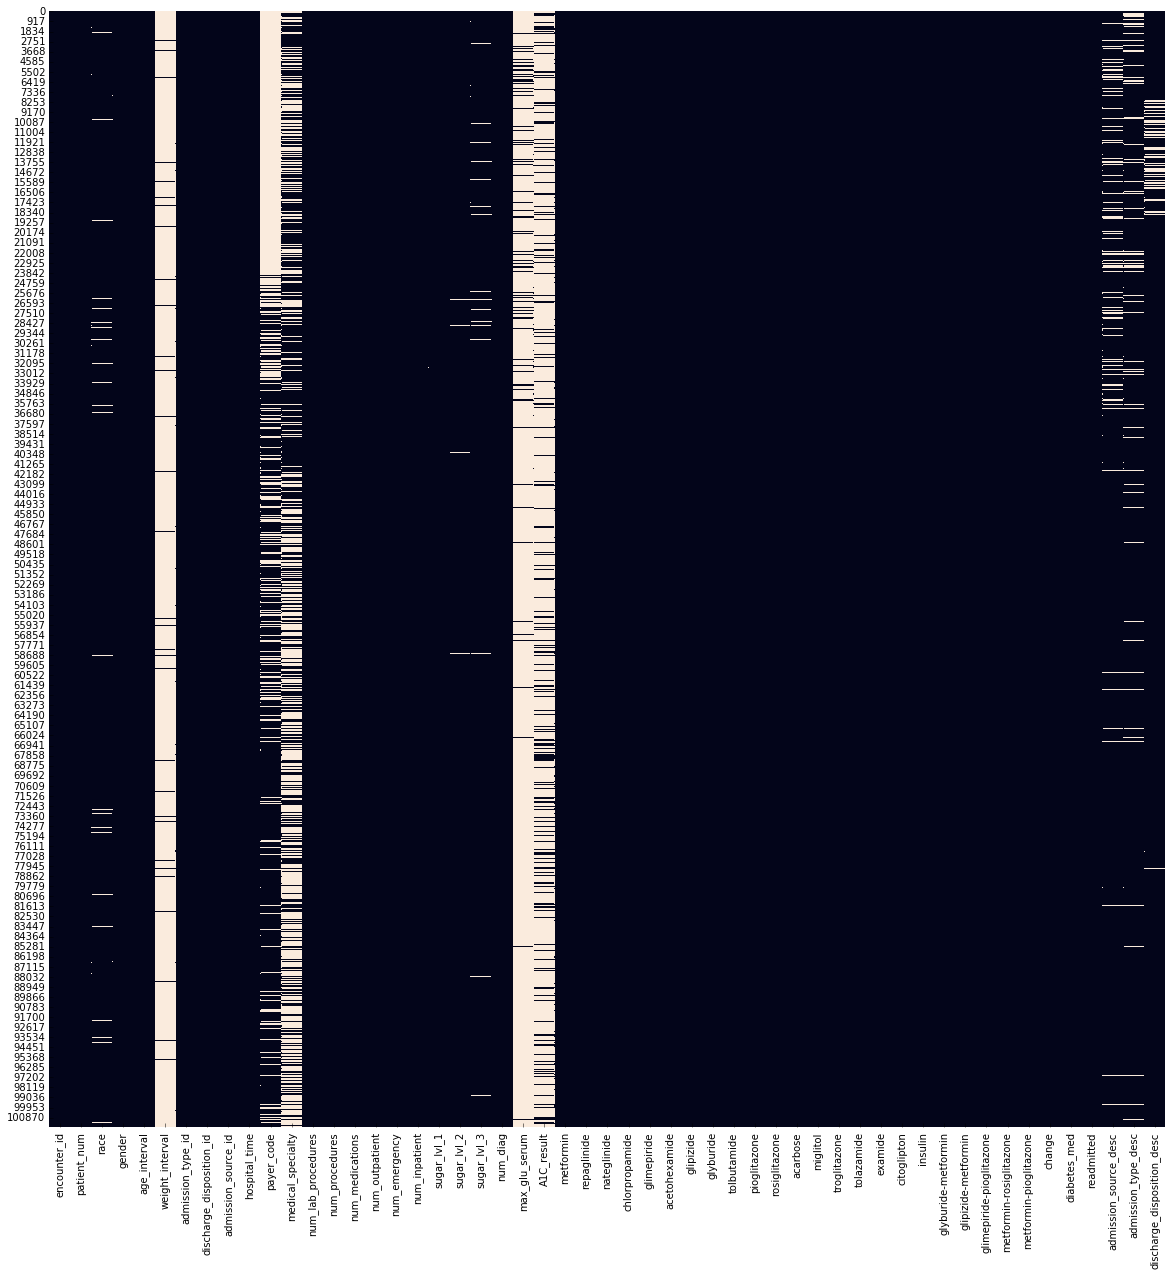

In [32]:
## Weigth, max_glu_serum, A1C_result have a bug distribution of nulls but it doesn't seem to be correlated
## Payer code is null in the first results this may be because this field was added later on in the process
plt.figure(figsize=(20,20))
sns.heatmap(complete_df.isnull(),cbar=False)
plt.show()

### Studying outliers

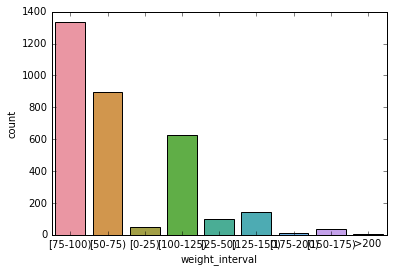

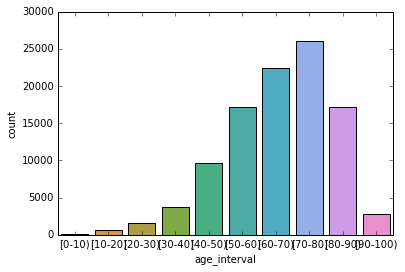

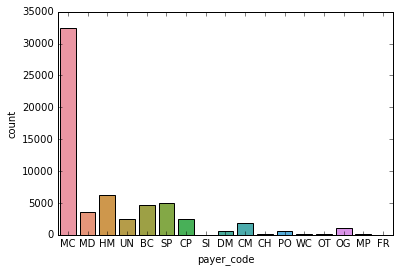

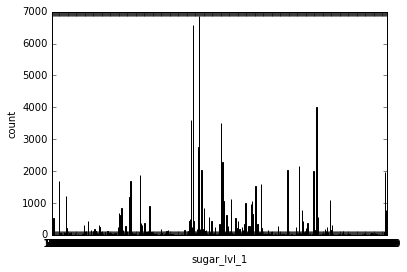

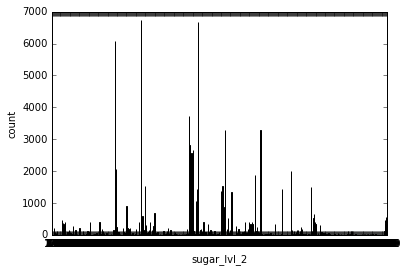

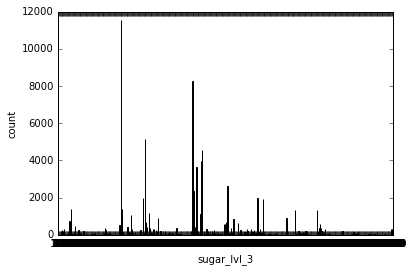

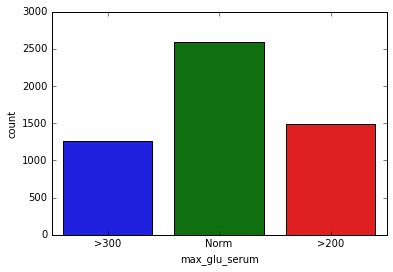

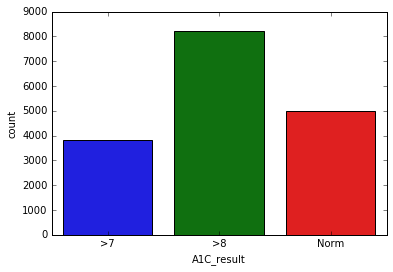

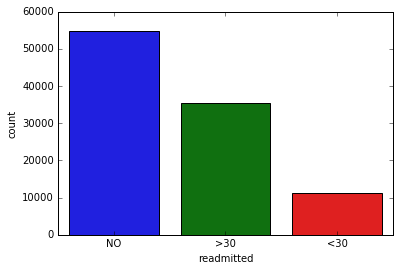

In [33]:
"""We found outliers in weight >200"""
"""age interval 0-10 is an outlier"""
"""we found mostly all the payer codes are MC"""

for col in research_cols:
    sns.countplot(x=col, data=complete_df)
    plt.show()

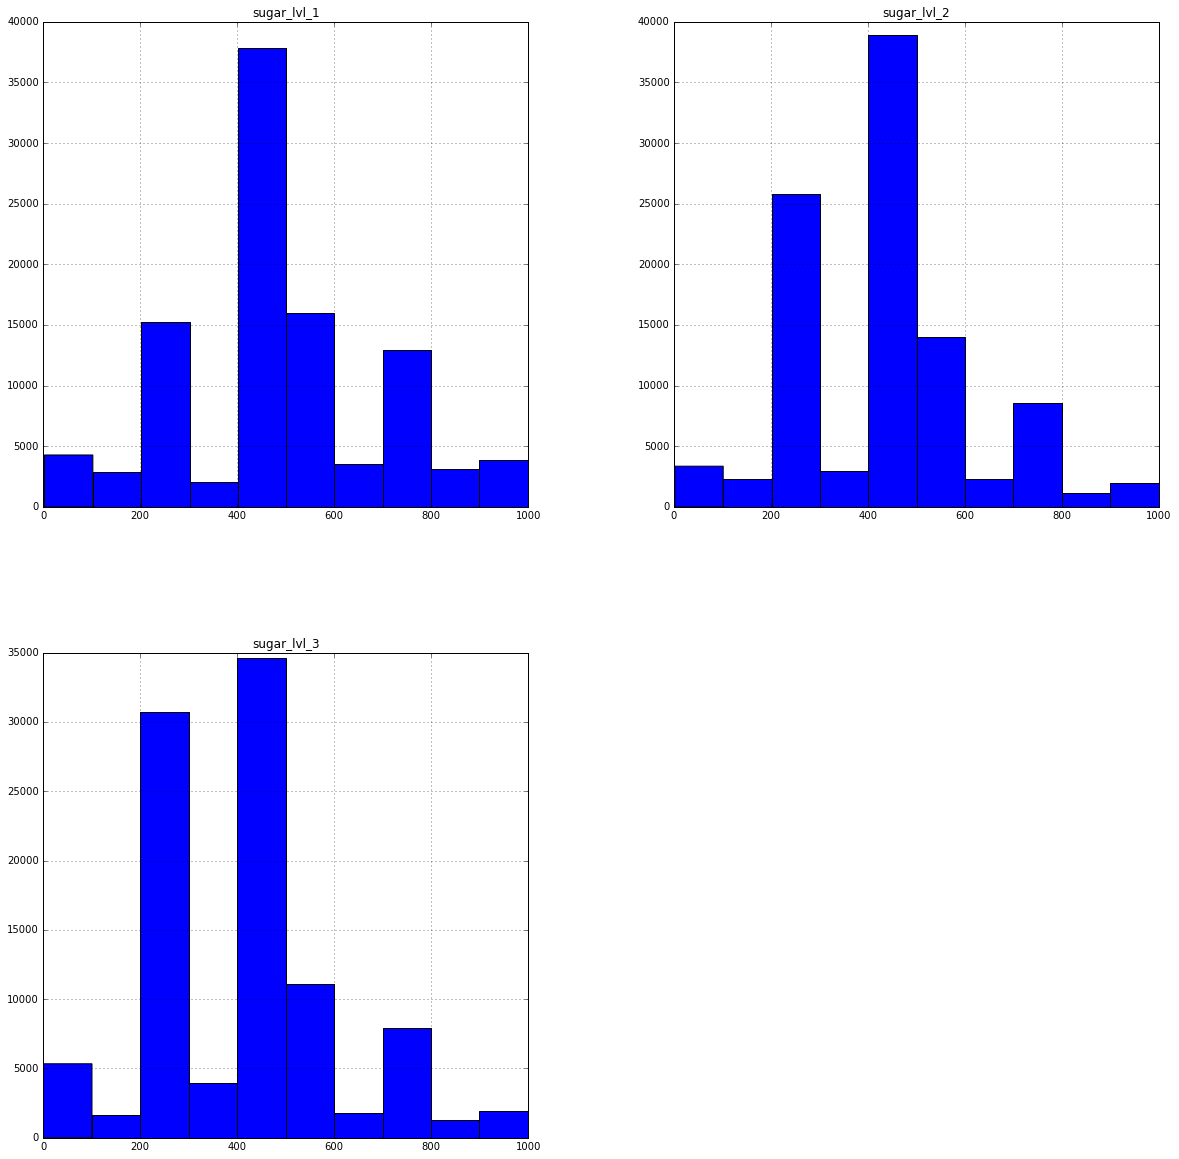

In [34]:
complete_df[research_cols].hist(figsize=(20,20))
plt.show()

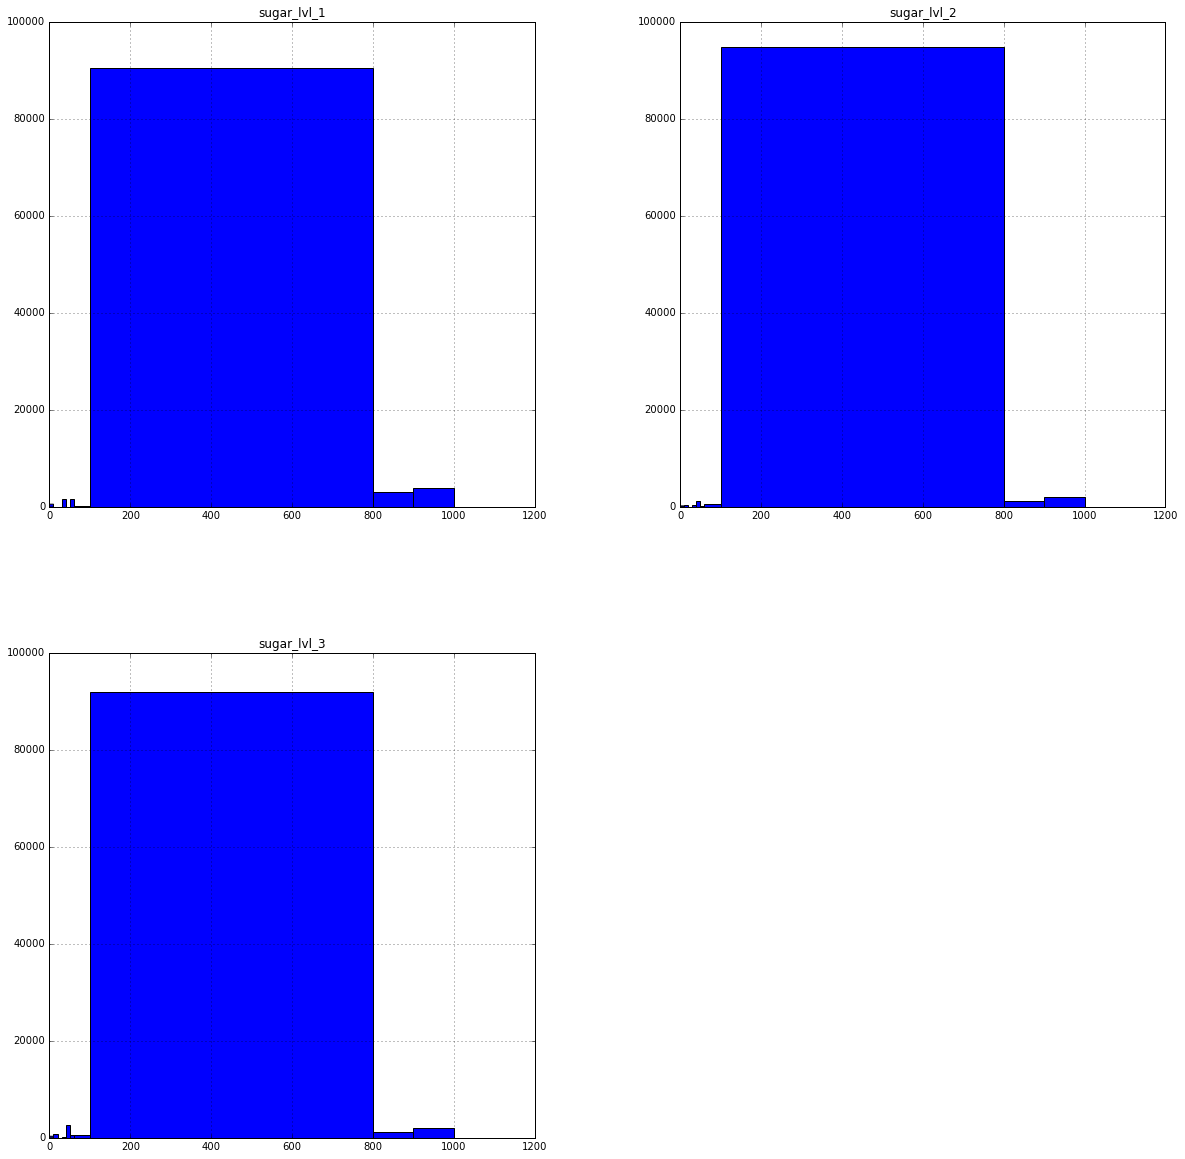

In [35]:
## We want to analyze the big population so we will drop records with sugar_lvl smaller than 50

complete_df[research_cols].hist(figsize=(20,20), bins=[0,10,20,30,40,50,60,100,800,900, 1000, 1100])
plt.show()

### Create dummy variables if necessary

In [36]:
## We want dummy variables in age, weight, payer_code, gender, race,

#complete_df.info()
#complete_df = deepcopy(checkpoint)

dummy_cols = ['age_interval','weight_interval', 'payer_code', 'gender', 'race', 'insulin', 'readmitted']
#dummy_cols = ['readmitted']
def create_dummy(df, dummy_cols):
    for col in dummy_cols:
        values = (df[col].value_counts() / df[col].value_counts().sum())
        values_cumsum = values.cumsum()

        df = df.join(values, on=col, rsuffix='_dummy')
        df  = df.join(values_cumsum, on=col, rsuffix='_cumsum_dummy')

    return df

complete_df = create_dummy(complete_df, dummy_cols)

### Analize if all variables have already the right format and content. If not, fix them.

In [35]:
# This is more 1.3.9. 1.3.8 was done before when we cleaned from ? and None strings some variables

complete_df['type_2_diabetes'] = complete_df['A1C_result'].apply(lambda x : 1 if x in ('>7', '>8')  else (0 if x == 'Norm' else None))

complete_df['type_2_diabetes'].value_counts()

1.0    12028
0.0     4990
Name: type_2_diabetes, dtype: int64

In [36]:
complete_df['readmitted_flag'] = complete_df['readmitted'].apply(lambda x : 1 if x in ('<30', '>30')  else (0 if x.upper() == 'NO' else None))

complete_df['readmitted_flag'].value_counts()

0    54864
1    46902
Name: readmitted_flag, dtype: int64

In [37]:
complete_df['insulin_reaction'] = complete_df['insulin'].apply(lambda x : 1 if x in ('Down', 'Up')  else (0 if x == 'Steady' else None))

complete_df['insulin_reaction'].value_counts()

0.0    30849
1.0    23534
Name: insulin_reaction, dtype: int64

In [38]:
complete_df['five_or_more'] = complete_df['hospital_time'].apply(lambda x : 1 if x >=5  else 0)
complete_df['four_or_more'] = complete_df['hospital_time'].apply(lambda x : 1 if x >=4 else 0)


In [39]:
## we save because we lost it all

checkpoint = save_point(complete_df)
checkpoint.head()

,encounter_id,patient_num,race,gender,age_interval,weight_interval,admission_type_id,discharge_disposition_id,admission_source_id,hospital_time,...,race_cumsum_dummy,insulin_dummy,insulin_cumsum_dummy,readmitted_dummy,readmitted_cumsum_dummy,type_2_diabetes,readmitted_flag,insulin_reaction,five_or_more,four_or_more
0,2278392,8222157,Caucasian,Female,[0-10),None,6,25,1,1,...,0.764868,0.465607,0.465607,0.539119,0.539119,NaN,0,NaN,0,0
1,149190,55629189,Caucasian,Female,[10-20),None,1,1,7,3,...,0.764868,0.111196,1.000000,0.349282,0.888401,NaN,1,1.0,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),None,1,1,7,2,...,0.957947,0.465607,0.465607,0.539119,0.539119,NaN,0,NaN,0,0
3,500364,82442376,Caucasian,Male,[30-40),None,1,1,7,2,...,0.764868,0.111196,1.000000,0.539119,0.539119,NaN,0,1.0,0,0
4,16680,42519267,Caucasian,Male,[40-50),None,1,1,7,1,...,0.764868,0.303137,0.768744,0.539119,0.539119,NaN,0,0.0,0,0


In [40]:
complete_df.info()
complete_df['A1C_result'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 72 columns):
encounter_id                    101766 non-null int64
patient_num                     101766 non-null int64
race                            99493 non-null object
gender                          101766 non-null object
age_interval                    101766 non-null object
weight_interval                 3197 non-null object
admission_type_id               101766 non-null int64
discharge_disposition_id        101766 non-null int64
admission_source_id             101766 non-null int64
hospital_time                   101766 non-null int64
payer_code                      61510 non-null object
medical_specialty               51817 non-null object
num_lab_procedures              101766 non-null int64
num_procedures                  101766 non-null int64
num_medications                 101766 non-null int64
num_outpatient                  101766 non-null int64
num_emergency           

>8      8216
Norm    4990
>7      3812
Name: A1C_result, dtype: int64

### Before studying the behavior of the variables, analize if there is any derived variable to create.

In [41]:
cols_related = ['max_glu_serum','sugar_lvl_1','sugar_lvl_2','sugar_lvl_3']
complete_df[~complete_df['max_glu_serum'].isnull()][cols_related].head()

## We were trying to find relation between those ranges and the sugar levels to create a new variable but it was
## not succesful

,max_glu_serum,sugar_lvl_1,sugar_lvl_2,sugar_lvl_3
133,>300,574.0,250.02,276.00
135,>300,491.0,250.03,999.00
142,Norm,682.0,428.00,250.03
144,Norm,560.0,997.00,276.00
153,Norm,427.0,228.00,529.00


# Exploratory Data Analysis

### Create a correlation matrix

In [42]:
complete_df.corr().head()

,encounter_id,patient_num,admission_type_id,discharge_disposition_id,admission_source_id,hospital_time,num_lab_procedures,num_procedures,num_medications,num_outpatient,...,race_cumsum_dummy,insulin_dummy,insulin_cumsum_dummy,readmitted_dummy,readmitted_cumsum_dummy,type_2_diabetes,readmitted_flag,insulin_reaction,five_or_more,four_or_more
encounter_id,1.000000,0.512028,-0.158961,-0.132876,-0.112402,-0.062221,-0.026062,-0.014225,0.076113,0.103756,...,-0.061592,-0.137128,0.130453,0.030125,-0.036571,-0.101134,-0.038267,0.134394,-0.051401,-0.047171
patient_num,0.512028,1.000000,-0.011128,-0.136814,-0.032568,-0.024092,0.015946,-0.015570,0.020665,0.103379,...,-0.087006,-0.057387,0.047105,-0.053774,0.069222,-0.086910,0.074093,0.101488,-0.018235,-0.014293
admission_type_id,-0.158961,-0.011128,1.000000,0.083483,0.106654,-0.012500,-0.143713,0.129888,0.079535,0.026511,...,-0.078724,0.011921,-0.017615,0.009463,-0.006653,0.060176,-0.004923,0.044134,-0.009272,-0.016927
discharge_disposition_id,-0.132876,-0.136814,0.083483,1.000000,0.018193,0.162748,0.023415,0.015921,0.108753,-0.008715,...,-0.004628,0.029083,-0.035821,-0.016825,-0.004251,0.004009,-0.014852,0.034346,0.140396,0.138805
admission_source_id,-0.112402,-0.032568,0.106654,0.018193,1.000000,-0.006965,0.048885,-0.135400,-0.054533,0.027244,...,-0.016096,-0.021741,0.017155,-0.029846,0.037645,0.018195,0.039986,0.031136,-0.004857,-0.001179


### Paint the correlation matrix

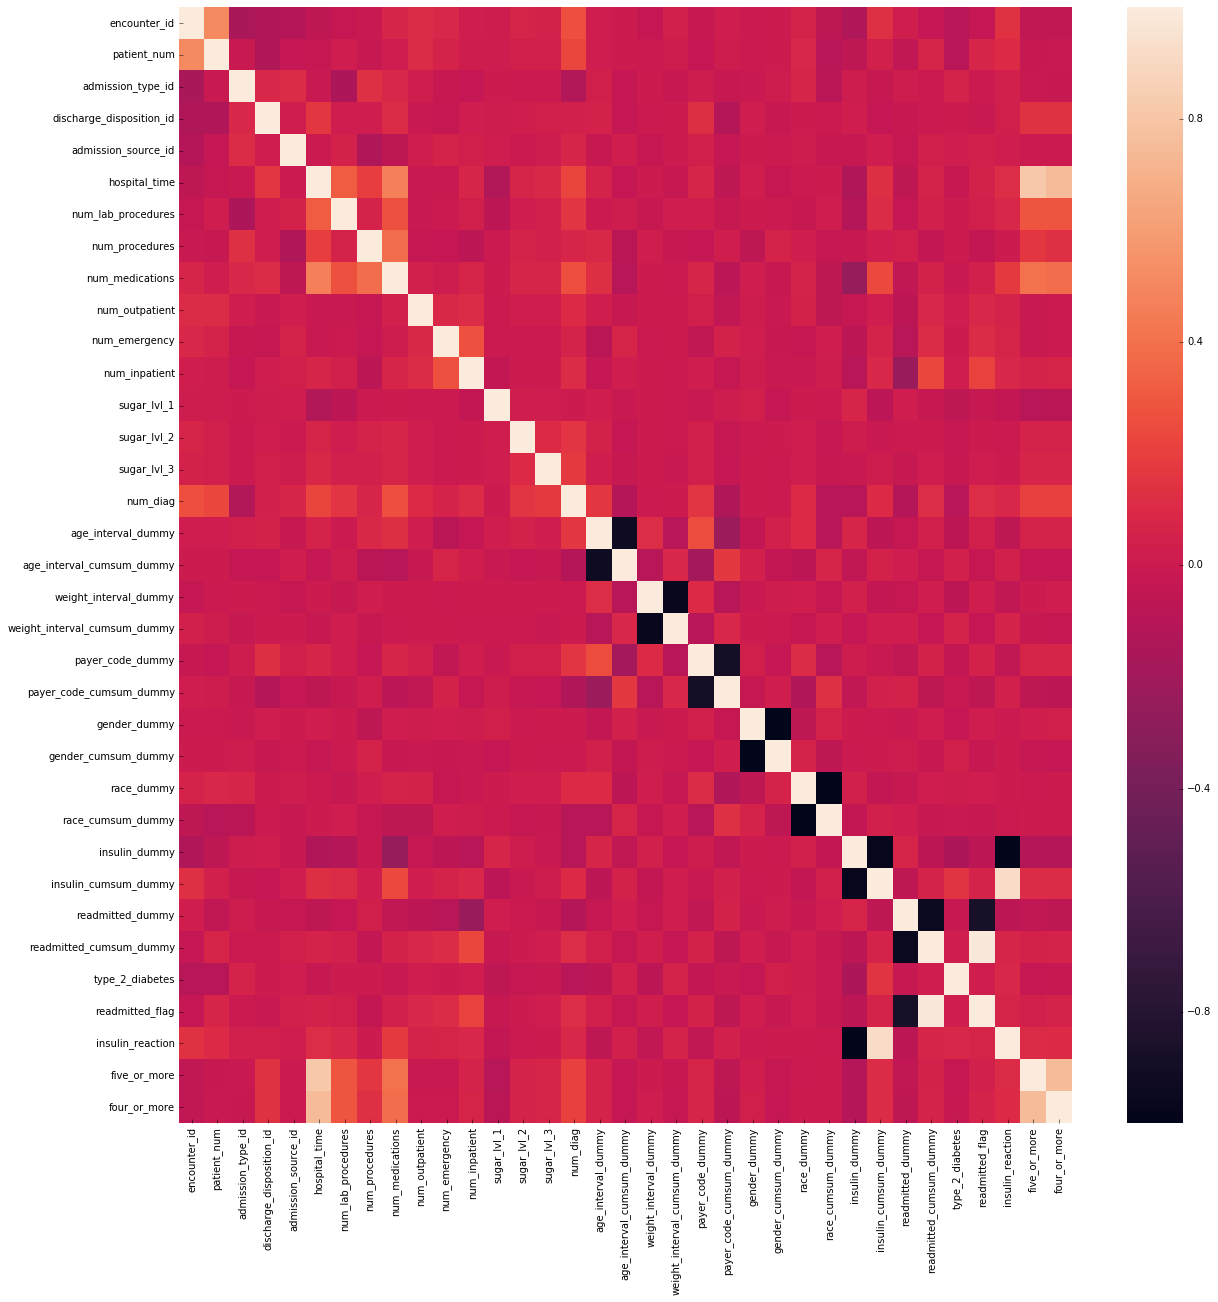

In [43]:
plt.figure(figsize=(20,20))
sns.heatmap(complete_df.corr())
plt.show()

### Determine which pair of variables are correlated

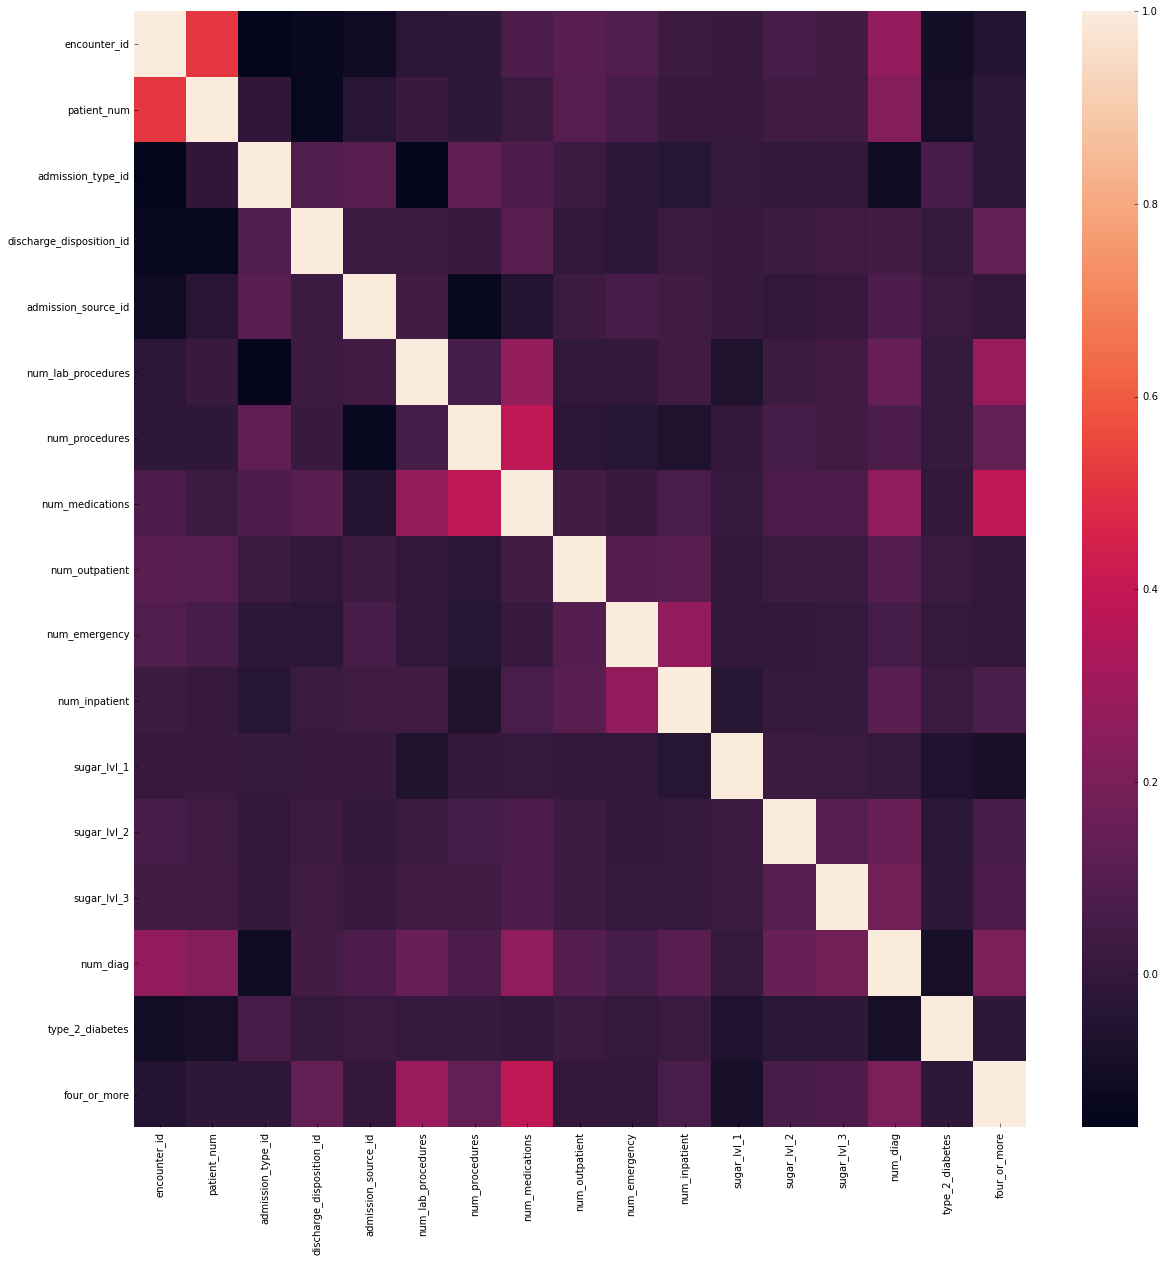

In [44]:
## Variables correlated in less that .8

plt.figure(figsize=(20,20))
m = ~(complete_df.corr().mask(np.eye(len(complete_df.corr()), dtype=bool)).abs() > 0.8).any()

raw = complete_df.corr().loc[m, m]
sns.heatmap(raw)
plt.show()

### Study the pairs of correlated variables to keep only one of the pair.

In [45]:
# We want to remove really strong correlations against our target.

corr = complete_df.corr().abs()[complete_df.corr().abs() < 0.9]
corr_list = corr.unstack()

corr_list.sort_values(kind="quicksort", ascending=False).loc['five_or_more']

# We want to remove the correlation between hospital_time and insuling_cumsum and insulin_reaction to no have 3
# features impacting our model.
# Spearman should give us a perfect corr

hospital_time                   0.812674
four_or_more                    0.756953
num_medications                 0.400042
num_lab_procedures              0.283895
num_diag                        0.195601
num_procedures                  0.162252
discharge_disposition_id        0.140396
insulin_dummy                   0.109458
insulin_cumsum_dummy            0.104750
insulin_reaction                0.101852
sugar_lvl_1                     0.100176
sugar_lvl_3                     0.075177
payer_code_dummy                0.068060
num_inpatient                   0.062138
sugar_lvl_2                     0.061895
age_interval_dummy              0.058384
payer_code_cumsum_dummy         0.055304
readmitted_dummy                0.052377
encounter_id                    0.051401
readmitted_cumsum_dummy         0.049697
readmitted_flag                 0.046146
age_interval_cumsum_dummy       0.036994
gender_cumsum_dummy             0.025954
gender_dummy                    0.025921
type_2_diabetes 

# Modeling

### Variables selection

In [46]:
target = 'five_or_more'
features = [x for x in corr_list.loc[target].index if corr_list.loc[target][x] > 0.1]

## we don't want variables referencing the same impacting our model.

features.remove('insulin_cumsum_dummy')
features.remove('insulin_reaction')
features.remove('four_or_more')
features.remove('hospital_time')

In [47]:
features, target

(['discharge_disposition_id',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'sugar_lvl_1',
  'num_diag',
  'insulin_dummy'],
 'five_or_more')

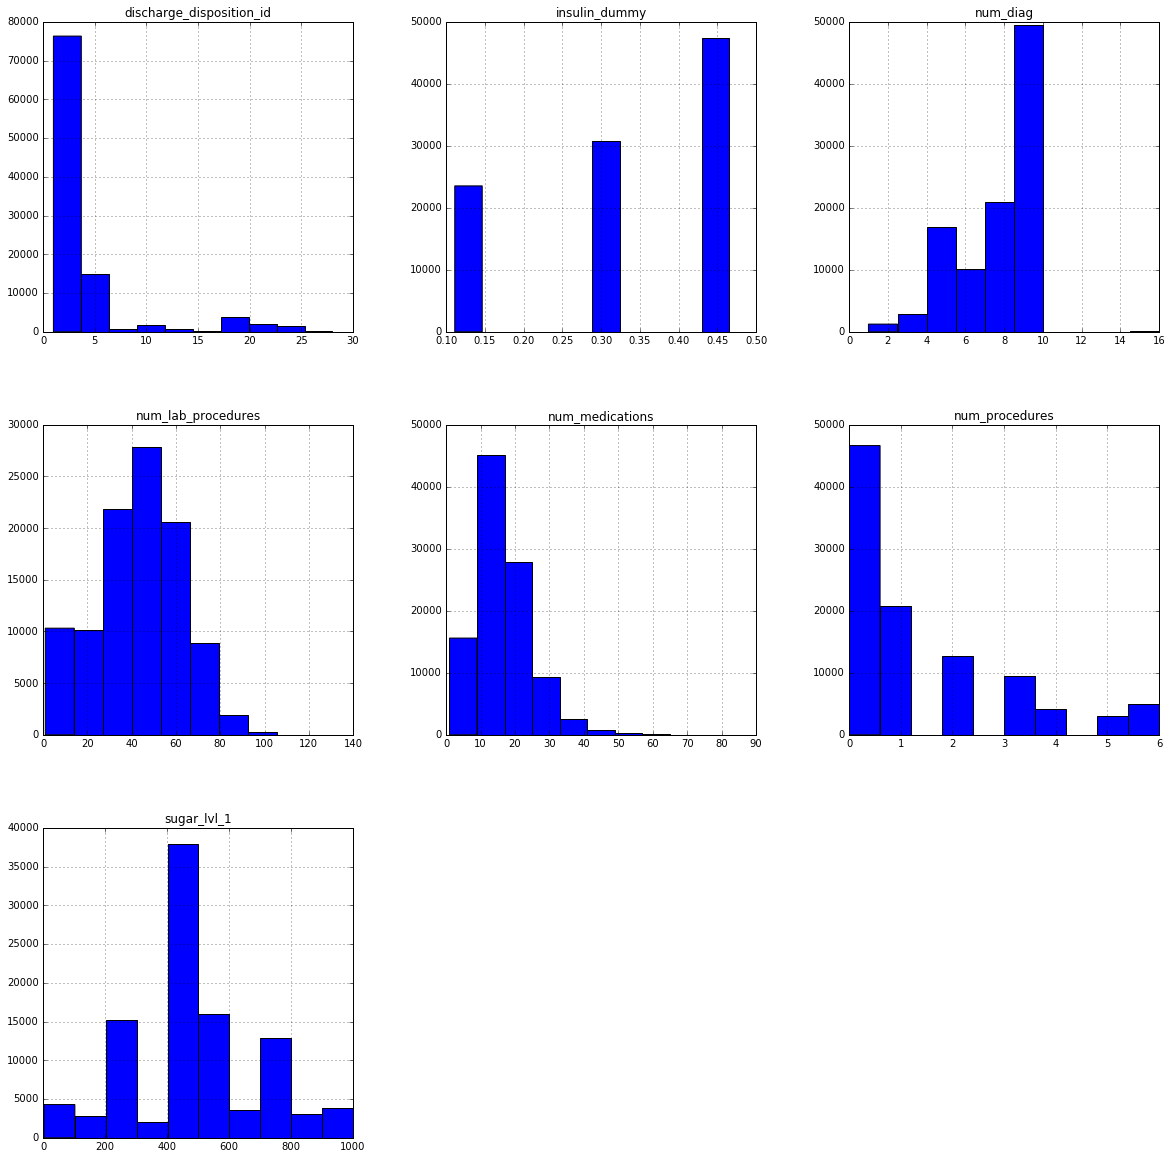

In [48]:
complete_df[features].hist(figsize=(20,20))
plt.show()

In [49]:
complete_df[features].dtypes

discharge_disposition_id      int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
sugar_lvl_1                 float64
num_diag                      int64
insulin_dummy               float64
dtype: object

### Standardize variables

In [50]:
all_vars = features  + [target]

In [51]:
# replace missing columns with their means
means = complete_df[all_vars].mean()
df_full_mean = complete_df[all_vars].fillna(means)

In [52]:
#split into train and test sets

x_train, x_test, y_train, y_test = train_test_split(df_full_mean[features], df_full_mean[target], 
                                                   random_state=seed)

In [55]:
# Pipeline to estimate knn regression
pipeline =Pipeline([
        ('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier())  
    ])

param_grid = {'knn__n_neighbors': [3,5,10,50], 
             'knn__leaf_size': [30,35]}

grid_KNN = GridSearchCV(estimator = pipeline, param_grid = param_grid,
                    cv=StratifiedKFold(y=y_train,n_folds=5,random_state=seed), verbose=1)

In [56]:
# fit knn estimation
grid_KNN.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.6min finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ... 0 0], n_folds=5, shuffle=False, random_state=1),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__leaf_size': [30, 35], 'knn__n_neighbors': [3, 5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [57]:
## We were doing a regression before but just getting .34 score. So we defined a new target.
## this new target will define if the patient is going to stay longer than 5 days
## Being a binomial target make it more easy to predict.
grid_KNN.best_score_

0.740749960693884

In [58]:
grid_KNN.best_params_

{'knn__leaf_size': 30, 'knn__n_neighbors': 50}

In [59]:
y_pred = grid_KNN.predict(x_test)

In [60]:
## One potential improvement will be to include more 1 in our training population so the model is able to learn
## more patterns.

print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.75      0.87      0.81     15858
          1       0.71      0.52      0.60      9584

avg / total       0.74      0.74      0.73     25442



### Run different algorithms

In [61]:
## We are going to try some supper vector machines (polynomial, linear and rbf)
pipeline =Pipeline([
        ('scaler', StandardScaler()), 
        ('svm', svm.SVC())  
    ])

param_grid = {'svm__kernel': ['linear']}

grid_SVM = GridSearchCV(estimator = pipeline, param_grid = param_grid,
                    cv=StratifiedKFold(y=y_train,n_folds=2,random_state=seed), verbose=5)


In [62]:
grid_SVM.fit(x_train,y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] svm__kernel=linear ..............................................
[CV] ..... svm__kernel=linear, score=0.7284733504533305, total=  52.4s
[CV] svm__kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] ..... svm__kernel=linear, score=0.7284995545306849, total=  52.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ... 0 0], n_folds=2, shuffle=False, random_state=1),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svm__kernel': ['linear']}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=5)

In [63]:
grid_SVM.best_score_

0.7284864524920077

In [64]:
grid_SVM.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [65]:
y_pred = grid_SVM.predict(x_test)

In [66]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.74      0.88      0.80     15858
          1       0.70      0.49      0.58      9584

avg / total       0.73      0.73      0.72     25442



### Evaluate the algorithms to determine which one is the best

In [67]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    """ We split the classification report by end of line
    then we loop trought all the lines to get the different values
    if we want the averate we know that we have them at the bottom but 
    usually we will want to plot the specific values """
    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

[0.74, 0.88, 0.8]
[0.7, 0.49, 0.58]


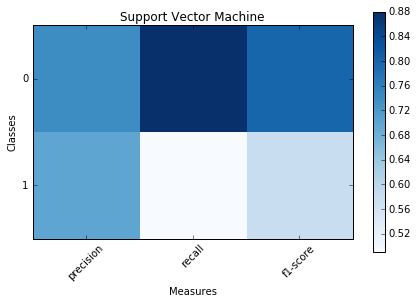

[0.75, 0.87, 0.81]
[0.71, 0.52, 0.6]


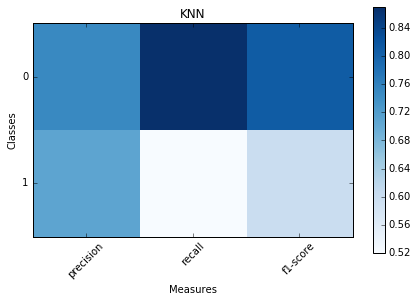

In [70]:
plot_classification_report(classification_report(y_true=y_test, y_pred=grid_SVM.predict(x_test)), title='Support Vector Machine')
plot_classification_report(classification_report(y_true=y_test, y_pred=grid_KNN.predict(x_test)),title= 'KNN')

# EXTRA

### Clustering those patients who have at least been readmitted once 

---



In [135]:
target = 'readmitted_flag'

cluster_df_0 = complete_df[complete_df[target] != 1]
cluster_df_1 = complete_df[complete_df[target] != 0]

num_cols_0 = cluster_df_0.select_dtypes(np.number).columns
num_cols_1 = cluster_df_1.select_dtypes(np.number).columns


# replace missing columns with their means
cluster_means_0 = cluster_df_0[num_cols_0].mean()
cluster_df_mean_0 = cluster_df_0[num_cols_0].fillna(cluster_means)

cluster_means_1 = cluster_df_1[num_cols_1].mean()
cluster_df_mean_1 = cluster_df_1[num_cols_1].fillna(cluster_means)

In [154]:
# For PCA we need to normalize the data. For that we use MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(cluster_df_mean_0)
cluster_reduce_0 = PCA(n_components=2).fit_transform(scaler.transform(cluster_df_mean_0))

scaler.fit(cluster_df_mean_1)
cluster_reduce_1 = PCA(n_components=2).fit_transform(scaler.transform(cluster_df_mean_1))

In [155]:
cluster_reduce_0.shape, cluster_reduce_1.shape

((54864, 2), (46902, 2))

In [156]:
kmeans = KMeans(n_clusters=9, verbose=0)
kmeans.fit(cluster_reduce_0)
y_pred_0 = kmeans.predict(cluster_reduce_0)
centers_0 = kmeans.cluster_centers_

kmeans = KMeans(n_clusters=2, verbose=0)
kmeans.fit(cluster_reduce_1)
y_pred_1 = kmeans.predict(cluster_reduce_1)
centers_1 = kmeans.cluster_centers_


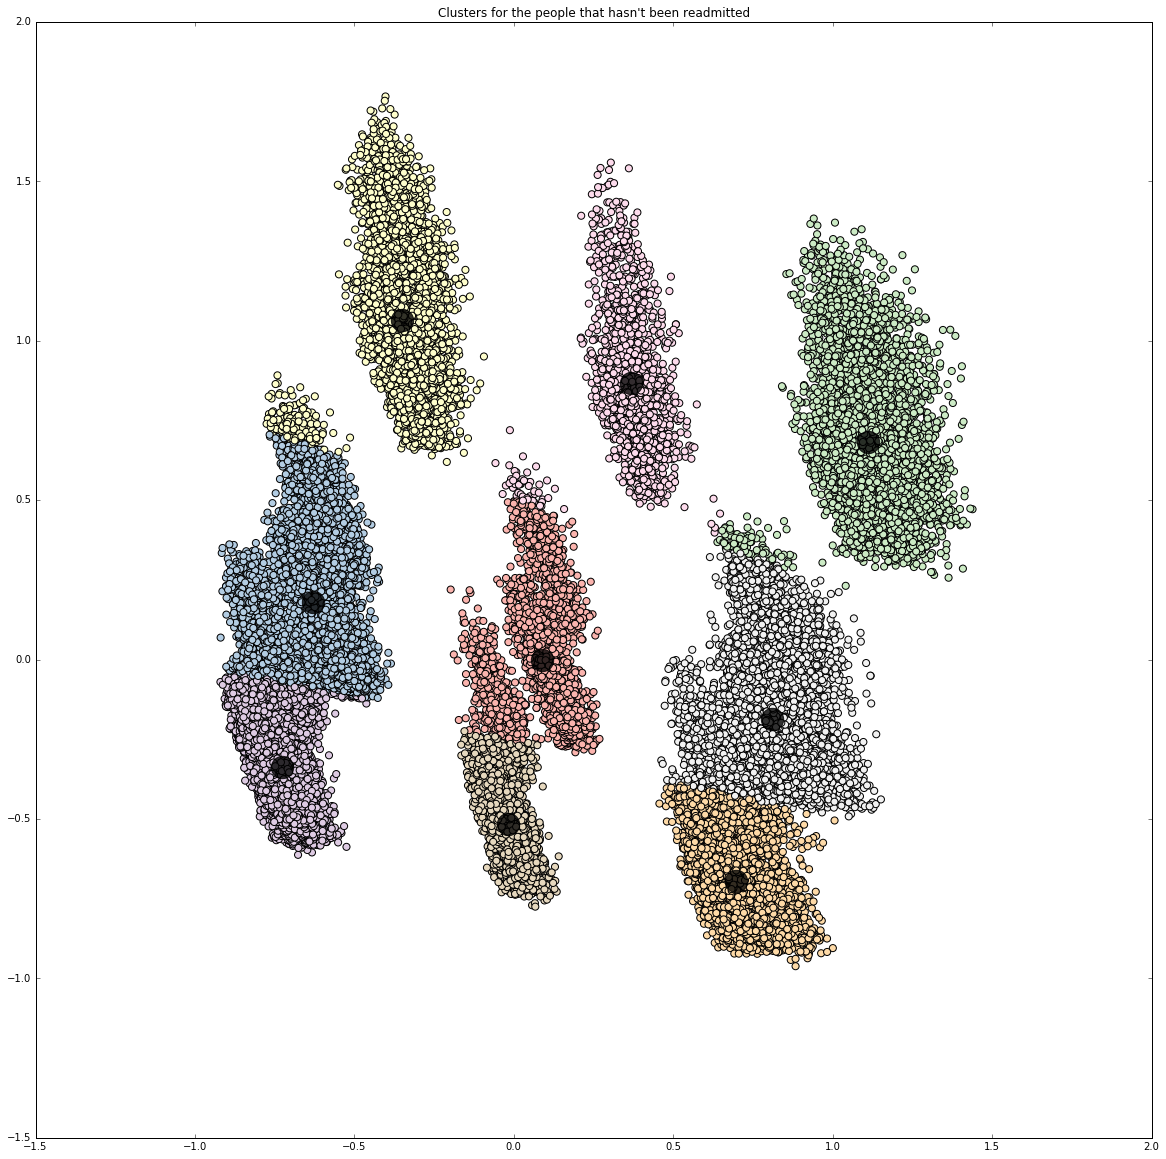

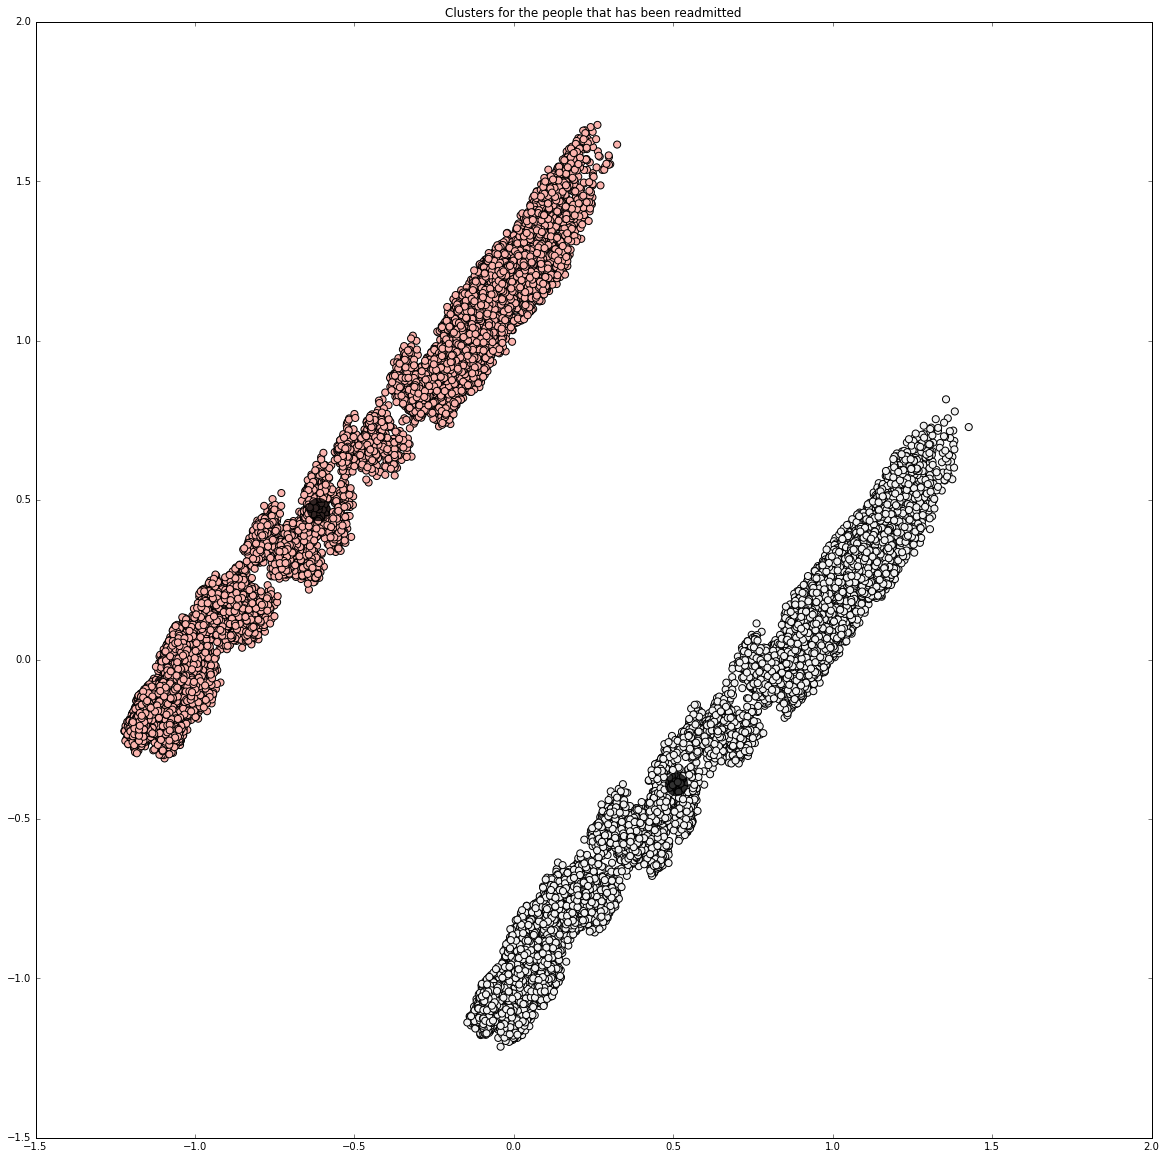

In [159]:
#plt.subplot(1,2,1)
plt.figure(figsize=(20,20))
plt.title("Clusters for the people that hasn't been readmitted")
plt.scatter(cluster_reduce_0[:,0], cluster_reduce_0[:,1], c= y_pred_0, s=50, cmap='Pastel1')
plt.scatter(centers_0[:,0], centers_0[:,1],c='black', s=500, alpha=.8)
plt.show()
#plt.subplot(1,2,2)
plt.figure(figsize=(20,20))
plt.title("Clusters for the people that has been readmitted")
plt.scatter(cluster_reduce_1[:,0], cluster_reduce_1[:,1], c= y_pred_1, s=50, cmap='Pastel1')
plt.scatter(centers_1[:,0], centers_1[:,1],c='black', s=500, alpha=.8)
plt.show()

In [121]:
pipeline =Pipeline([
        ('scaler', MinMaxScaler()), 
        ('pca', PCA(n_components=3)),
        ('kmeans', KMeans(n_clusters=3, verbose=1, random_state=seed))  
    ])

#split into train and test sets
#x_train, x_test, y_train, y_test = train_test_split(cluster_df_mean[num_cols], cluster_df_mean[target], 
#                                                   random_state=seed)

pipeline.fit(cluster_df_mean[num_cols])

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 37161.95488297418
start iteration
done sorting
end inner loop
Iteration 1, inertia 36730.418926660604
start iteration
done sorting
end inner loop
Iteration 2, inertia 35204.229242321795
start iteration
done sorting
end inner loop
Iteration 3, inertia 32094.209833752317
start iteration
done sorting
end inner loop
Iteration 4, inertia 31586.189625368264
start iteration
done sorting
end inner loop
Iteration 5, inertia 31510.53865065329
start iteration
done sorting
end inner loop
Iteration 6, inertia 31505.962782217222
start iteration
done sorting
end inner loop
Iteration 7, inertia 31505.909663652317
center shift 1.073048e-03 within tolerance 4.511743e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 36978.98287714842
start iteration
done sorting
end inner loop
Iteration 1, inertia 33592.61014306432
start iteration
done sorting
end inner loop
Iteration 2, ine

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=1))])

In [122]:
pipeline.named_steps.kmeans.labels_

array([1, 2, 2, ..., 1, 1, 2], dtype=int32)

In [98]:
pipeline.named_steps.kmeans.cluster_centers_

array([[ 1.88308436, -0.37316508, -0.28243288],
       [-0.83084677,  2.04419052, -0.42592626],
       [-1.34136461, -0.82427246,  0.52048241]])

In [123]:
y_pred = pipeline.predict(cluster_df_mean[num_cols])
y_pred

array([1, 2, 2, ..., 1, 1, 2], dtype=int32)

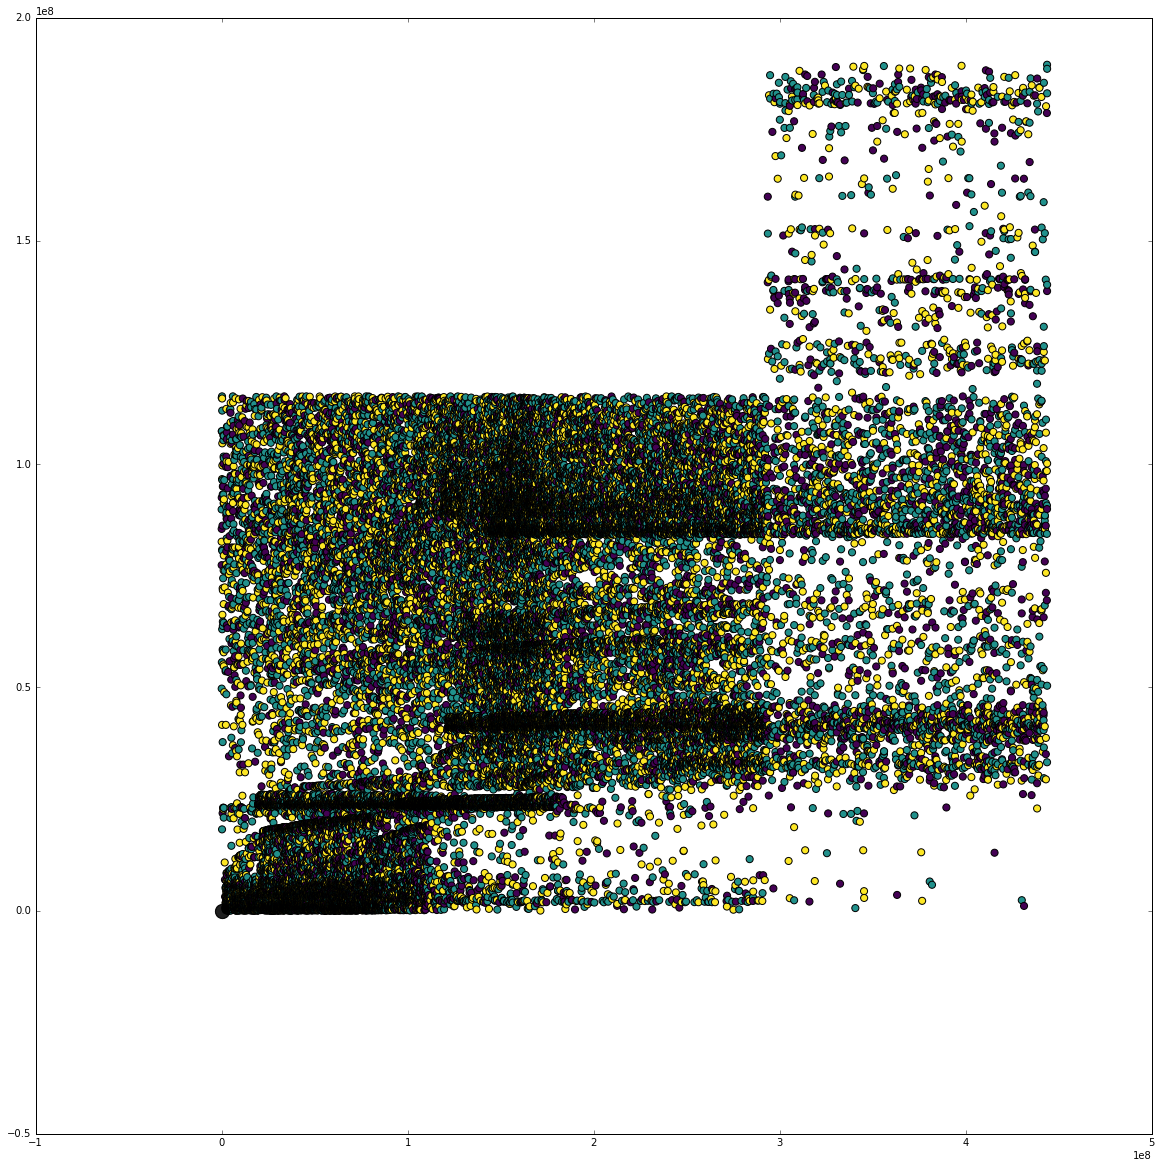

In [124]:
plt.figure(figsize=(20,20))
plt.scatter(cluster_df_mean[num_cols].iloc[:,0], cluster_df_mean[num_cols].iloc[:,1], c= y_pred, s=50, cmap='viridis')
centers = pipeline.named_steps.kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1],c='black', s=200, alpha=.5)
plt.show()